In [1]:
import numpy as np
import cv2
import mediapipe as mp
import os
import pandas as pd
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from time import perf_counter_ns
import sqlite3
import json
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

from functions_ml import refactor_video_into_input

In [3]:
IMAGE_SIZE = (256, 256)
SEQUENCE_LENGTH = 25
POSE_START_INDEX = 11
POSE_END_INDEX = 23

IMG_DIR = 'test_img'
RECORDINGS_DIR = 'recordings'
LOADED_VIDEOS_DIR = 'loaded_videos'
TESTING_VIDEO = "hello_video_1.mp4"
TESTIING_IMG = "pawel_test.png"

DB_NAME = 'slr.db'
TABLE_NAME = 'sign_videos'

DETECTOR_MODEL_NAME = 'pose_landmarker_full.task'

In [4]:
os.getcwd()

'c:\\Users\\Piotr.Matys\\Python_Projects\\Computer-Vision-Sign-Language\\jupyter_notebooks'

In [5]:
with open(DETECTOR_MODEL_NAME, 'rb') as det_bytes_model:
    model_data = det_bytes_model.read()

In [6]:
base_options = python.BaseOptions(model_asset_buffer=model_data)
running_mode = vision.RunningMode


detector_options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False,
    running_mode=running_mode.VIDEO)


In [7]:
img_path = os.path.join(IMG_DIR, TESTIING_IMG)
video_path = os.path.join("..", RECORDINGS_DIR, TESTING_VIDEO)

#### Testing what does that rotation do on simple image

In [8]:
img_pil = Image.open(img_path)
img_array = np.array(img_pil)

<img src="test_img/pawel_test.png" width="300" height="300">


In [9]:
img_array = cv2.resize(img_array, (256, 256))

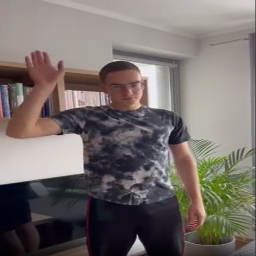

In [10]:
Image.fromarray(img_array)

In [11]:
img_array[:, :, 0].shape

(256, 256)

In [12]:
img_height, img_width = img_array.shape[:2]

In [64]:
a_factor = 50

In [65]:
i_1_2 = (-1 * a_factor * img_width) / (2 * a_factor * img_height - img_height * img_width)
i_2_2 = (img_width) / (img_width - 2 * a_factor)
i_3_2 = (-2 * a_factor) / (2 * a_factor * img_height - img_height * img_width)

In [66]:
TRANS_MATRIX = np.array([
    [1, i_1_2, 0],
    [0, i_2_2, 0],
    [0, i_3_2, 1]
])

In [58]:
a, h, w = a_factor, img_height, img_width

In [50]:
from scipy.ndimage import affine_transform

In [54]:
img_array.shape

(256, 256, 3)

In [67]:
transformed_image = affine_transform(img_array, TRANS_MATRIX)

In [69]:
a = [1, 2, 3]

a[1:None]

[2, 3]

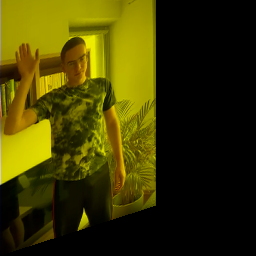

In [68]:
Image.fromarray(transformed_image)

In [28]:
x_values = np.arange(256)
y_values = np.arange(256)

# Create a grid of x, y values using meshgrid
x_grid, y_grid = np.meshgrid(x_values, y_values)

# Stack x and y grids to form a (256, 256, 2) array
points = np.stack((x_grid, y_grid), axis=-1)

# Add a third dimension with constant value 1 to points
points = np.concatenate((points, np.ones_like(x_grid)[:, :, np.newaxis]), axis=-1)

# Perform the dot product for all points



In [29]:
points

array([[[  0,   0,   1],
        [  1,   0,   1],
        [  2,   0,   1],
        ...,
        [253,   0,   1],
        [254,   0,   1],
        [255,   0,   1]],

       [[  0,   1,   1],
        [  1,   1,   1],
        [  2,   1,   1],
        ...,
        [253,   1,   1],
        [254,   1,   1],
        [255,   1,   1]],

       [[  0,   2,   1],
        [  1,   2,   1],
        [  2,   2,   1],
        ...,
        [253,   2,   1],
        [254,   2,   1],
        [255,   2,   1]],

       ...,

       [[  0, 253,   1],
        [  1, 253,   1],
        [  2, 253,   1],
        ...,
        [253, 253,   1],
        [254, 253,   1],
        [255, 253,   1]],

       [[  0, 254,   1],
        [  1, 254,   1],
        [  2, 254,   1],
        ...,
        [253, 254,   1],
        [254, 254,   1],
        [255, 254,   1]],

       [[  0, 255,   1],
        [  1, 255,   1],
        [  2, 255,   1],
        ...,
        [253, 255,   1],
        [254, 255,   1],
        [255, 255,   1]]

In [35]:
result_matrix = np.dot(points, TRANS_MATRIX)

In [36]:
result_matrix[0, 0], result_matrix[0, 1]

(array([0.        , 0.01395089, 1.        ]),
 array([1.        , 1.79966518, 1.        ]))

In [40]:
new_image_cords_x = np.zeros((256, 256))
new_image_cords_y = np.zeros((256, 256))

In [41]:
for i in range(256):
    for j in range(256):
        
        x, y, _ = TRANS_MATRIX @ np.array([i, j, 1])
        new_image_cords_x[i, j] = x
        new_image_cords_y[i, j] = y

In [42]:
new_image_cords_x

array([[  0.        ,   1.78571429,   3.57142857, ..., 451.78571429,
        453.57142857, 455.35714286],
       [  1.        ,   2.78571429,   4.57142857, ..., 452.78571429,
        454.57142857, 456.35714286],
       [  2.        ,   3.78571429,   5.57142857, ..., 453.78571429,
        455.57142857, 457.35714286],
       ...,
       [253.        , 254.78571429, 256.57142857, ..., 704.78571429,
        706.57142857, 708.35714286],
       [254.        , 255.78571429, 257.57142857, ..., 705.78571429,
        707.57142857, 709.35714286],
       [255.        , 256.78571429, 258.57142857, ..., 706.78571429,
        708.57142857, 710.35714286]])

In [43]:
new_image_cords_y

array([[   0.        ,    4.57142857,    9.14285714, ..., 1156.57142857,
        1161.14285714, 1165.71428571],
       [   0.        ,    4.57142857,    9.14285714, ..., 1156.57142857,
        1161.14285714, 1165.71428571],
       [   0.        ,    4.57142857,    9.14285714, ..., 1156.57142857,
        1161.14285714, 1165.71428571],
       ...,
       [   0.        ,    4.57142857,    9.14285714, ..., 1156.57142857,
        1161.14285714, 1165.71428571],
       [   0.        ,    4.57142857,    9.14285714, ..., 1156.57142857,
        1161.14285714, 1165.71428571],
       [   0.        ,    4.57142857,    9.14285714, ..., 1156.57142857,
        1161.14285714, 1165.71428571]])

In [21]:
x_diff = new_image_cords_x[0, 1] - new_image_cords_x[0, 0]
y_diff = new_image_cords_y[0, 1] - new_image_cords_y[0, 0]

In [22]:
x_factor = 1 / x_diff

In [23]:
x_coords_normalized = (new_image_cords_x * x_factor).astype(int)
y_coords_normalized = (new_image_cords_y * x_factor).astype(int)

In [24]:
x_coords_normalized

array([[  0,   1,   2, ..., 253, 254, 255],
       [  0,   1,   2, ..., 253, 254, 255],
       [  1,   2,   3, ..., 254, 255, 256],
       ...,
       [141, 142, 143, ..., 394, 395, 396],
       [142, 143, 144, ..., 395, 396, 397],
       [142, 143, 144, ..., 395, 396, 397]])

In [25]:
y_coords_normalized

array([[  0,   2,   5, ..., 647, 650, 652],
       [  0,   2,   5, ..., 647, 650, 652],
       [  0,   2,   5, ..., 647, 650, 652],
       ...,
       [  0,   2,   5, ..., 647, 650, 652],
       [  0,   2,   5, ..., 647, 650, 652],
       [  0,   2,   5, ..., 647, 650, 652]])

In [26]:
norm = lambda x: (x) / (np.max(x_coords_normalized)) * 256

x_coords_normalized_2 = norm(x_coords_normalized)

In [27]:
x_coords_normalized_2

array([[  0.        ,   0.64483627,   1.28967254, ..., 163.14357683,
        163.7884131 , 164.43324937],
       [  0.        ,   0.64483627,   1.28967254, ..., 163.14357683,
        163.7884131 , 164.43324937],
       [  0.64483627,   1.28967254,   1.93450882, ..., 163.7884131 ,
        164.43324937, 165.07808564],
       ...,
       [ 90.92191436,  91.56675063,  92.2115869 , ..., 254.06549118,
        254.71032746, 255.35516373],
       [ 91.56675063,  92.2115869 ,  92.85642317, ..., 254.71032746,
        255.35516373, 256.        ],
       [ 91.56675063,  92.2115869 ,  92.85642317, ..., 254.71032746,
        255.35516373, 256.        ]])

In [106]:
y_coords_normalized

array([[  0,   2,   5, ..., 645, 647, 650],
       [  0,   2,   5, ..., 645, 647, 650],
       [  0,   2,   5, ..., 645, 647, 650],
       ...,
       [  0,   2,   5, ..., 645, 647, 650],
       [  0,   2,   5, ..., 645, 647, 650],
       [  0,   2,   5, ..., 645, 647, 650]])

In [91]:
max(x_coords_normalized.flatten())

6248

In [64]:
import numpy as np

# Your points
points = np.array([
    [0., 0.],
    [0.04237288, 1.08474576],
    [0.08474576, 2.16949153],
    [0.12711864, 3.25423729]
])

# Calculate the common factor
common_factor = 1 / 0.04237288

# Multiply the points by the common factor
integer_points = (points * common_factor).astype(int)

print(integer_points)

[[ 0  0]
 [ 1 25]
 [ 2 51]
 [ 3 76]]


In [65]:
common_factor

23.600000755200025

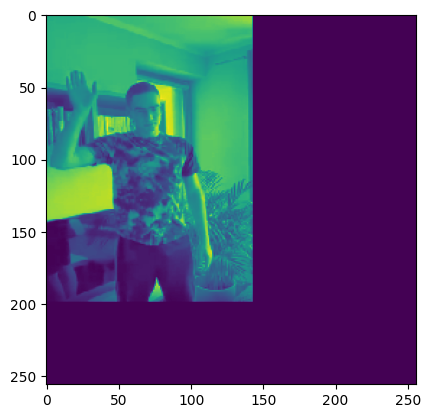

In [145]:
plt.imshow(image)
plt.show()

In [46]:
transformed_coordinates = result_matrix[0, 0]
transformed_coordinates

array([0.00000000e+00, 9.20471281e-04, 1.00000000e+00])

In [ ]:
res = np.dot(TRANS_MATRIX, )

In [ ]:
with vision.PoseLandmarker.create_from_options(detector_options) as key_points_detector:

    if not os.path.exists(video_path):
        print(f"Path: {video_path} does not exist")

    print(f"Processing: {video_path}")

    

    key_diff, keypoints = refactor_video_into_input(
        video_path=video_path,
        key_points_detector=key_points_detector,
        use_visibility=False,
        pose_indexes=(POSE_START_INDEX, POSE_END_INDEX),
        video_task=True
    )

    # except Exception as e:

    #     print(f"For {video_path} error occured: {e}")